# VGG + tensorboard + torchinfo + Epoch당 걸리는 시간


In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tr
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform


from VGG import VGG11, VGG13, VGG16, VGG19
import os
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from PIL import Image
import re
import PIL
import glob



path = "/home/sldev1/Project/hyeongeun_test/data/FER"


''' random seed fixed'''
import random
import torch.backends.cudnn as cudnn
import numpy as np

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [2]:
# Simple Learning Rate Scheduler
def lr_scheduler(optimizer, epoch):
    lr = learning_rate
    if epoch == 50:
        lr /= 2
    if epoch == 100:
        lr /= 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr 

# Xavier, 가중치 초기화 부분
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform(m.weight)

In [3]:
def img_load(img_path):

    jpg = glob.glob(img_path+'*.jpg')
    sort_jpg = sorted(jpg, key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("img_load def is play")
    return sort_jpg


def label_load(label_path):
    #enumerate #파이썬내장함수.. 강민규사원님은 이걸로 쓰셨는데 느리더래
    label = glob.glob(label_path+'*exp.npy')
    sort_label = sorted(label,key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("label_load def is play")
    return sort_label

class MyFERDataset(Dataset):
    
    def __init__(self, img_path_base, label_path_base, train=None, transform=None):
        super(MyFERDataset, self).__init__()
        
        if train == True:
            self.img_path = img_path_base+'/train_set/images/'
            self.label_path = label_path_base+'/train_set/annotations/'
        else:
            self.img_path = img_path_base+'/val_set/images/'
            self.label_path = label_path_base+'/val_set/annotations/'

        self.img = img_load(self.img_path)
        self.label = label_load(self.label_path)
        self.transform = transform
        
    
    def __getitem__(self, idx):
        img_read = io.imread(self.img[idx]) 
        label_read = np.load(self.label[idx])
        label_read = label_read.astype(np.int64)
        label_tr = torch.from_numpy(label_read)
        
        
        if self.transform:
            img_tr = self.transform(img_read)
        
        
        return img_tr, label_tr
    

    def __len__(self):
        return len(self.label)
    
    if __name__ == "__main__":
        print('hi, i\'m main')

hi, i'm main


In [4]:
transform_train = tr.Compose([tr.ToTensor(),
                              tr.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
transform_test = tr.Compose([tr.ToTensor()])


train_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=True,
                              transform=transform_train)
test_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=False,
                              transform=transform_test)

In [5]:
len(train_dataset)

287651

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [8]:
labels.size()
#print(images)

torch.Size([32])

In [9]:
print(labels)

tensor([0, 1, 0, 1, 1, 1, 0, 3, 0, 0, 6, 0, 1, 1, 1, 1, 0, 1, 0, 2, 3, 6, 1, 1,
        0, 0, 2, 1, 5, 1, 1, 6])


In [10]:
device = 'cuda'
model = VGG16()
# VGG11, VGG13, VGG16, VGG19 중에 택일하여 사용

In [11]:
model.apply(init_weights)
model = model.to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [12]:
learning_rate = 0.001
num_epoch = 200
model_name = 'VGG_FER.pth'

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

# 여기서 걸리는 시간 측정

In [13]:
import time
start = time.time() #시작 시간 저장
# Train
writer = SummaryWriter()
for epoch in range(num_epoch):
    
    if epoch == 1:
        start = time.time() #시작 시간 저장
    if epoch == 2:
        epoch_time_for_1 = time.time()-start
        timer = epoch_time_for_1 * num_epoch
        print("학습에 총 걸리는 시간 :", timer)

    
    
    
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    model.train()
    lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    
    
    #writer.add_scalar('Loss/train', train_loss, epoch)
    #writer.add_scalar('Loss/valid', np.random.random(), n_iter)
    #writer.add_scalar('Accuracy/train', valid_loss, epoch)
    #writer.add_scalar('Accuracy/valid', np.random.random(), n_iter)
    
    # Train Phase
    for step, batch in enumerate(train_loader):
        #  input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device) # batch[0]은 이미지 / batch[1]은 label
        optimizer.zero_grad()
        
        logits = model(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        _, predict = logits.max(1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        
        
        if step % 1000 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(train_loader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")

    
    train_acc_visual = (correct / total_cnt) * 100
    train_loss_visual = loss.item() / batch[1].size(0)
    writer.add_scalar('acc/train', train_acc_visual, epoch)
    writer.add_scalar('loss/train', train_loss_visual, epoch)

        
            
    correct = 0
    total_cnt = 0
    
# Test Phase
    with torch.no_grad():
        model.eval()
        for step, batch in enumerate(test_loader):
            # input and target
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
            total_cnt += batch[1].size(0)
            logits = model(batch[0])
            valid_loss += loss_fn(logits, batch[1])
            _, predict = logits.max(1)
            correct += predict.eq(batch[1]).sum().item()
        valid_acc = correct / total_cnt
        print(f"\nValid Acc : { valid_acc }")    
        print(f"Valid Loss : { valid_loss / total_cnt }")
        valid_acc_visual = valid_acc * 100
        valid_loss_visual = valid_loss / total_cnt
        writer.add_scalar('acc/valid', valid_acc_visual, epoch)
        writer.add_scalar('loss/valid', valid_loss_visual, epoch)

        if(valid_acc > best_acc):
            best_acc = valid_acc
            #torch.save(model, model_name)
            torch.save(model.state_dict(), model_name)
            print("Model Saved!")
    


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

====== 1 epoch of 200 ======

====== 1000 Step of 8990 ======
Train Acc : 0.49063436563436563
Train Loss : 0.032309286296367645

====== 2000 Step of 8990 ======
Train Acc : 0.5499437781109445
Train Loss : 0.05138865113258362

====== 3000 Step of 8990 ======
Train Acc : 0.5767556647784072
Train Loss : 0.030065201222896576

====== 4000 Step of 8990 ======
Train Acc : 0.5919145213696576
Train Loss : 0.03900831937789917

====== 5000 Step of 8990 ======
Train Acc : 0.6026419716056789
Train Loss : 0.02189450152218342

====== 6000 Step of 8990 ======
Train Acc : 0.6099504249291785
Train Loss : 0.031170399859547615

====== 7000 Step of 8990 ======
Train Acc : 0.6167333238108842
Train Loss : 0.017384855076670647

====== 8000 Step of 8990 ======
Train Acc : 0.6219574115735533
Train Loss : 0.03198539838194847

Valid Acc : 0.25881470367591897
Valid Loss : 0.07330921292304993
Model Saved!
====== 2 epoch of 200 ======

====== 1000 Step of 8990 ======
Train Acc : 0.6710789210789211
Train Loss : 0.031

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: 

In [15]:
model.load_state_dict(torch.load('./VGG_FER.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

In [16]:
from torchinfo import summary
summary(model, (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [17]:
label_tags = {
    0 : 'Neutral',
    1 : 'Happiness', #기쁨
    2 : 'Sadness', #슬픔
    3 : 'Suprise', #놀람
    4 : 'Fear', #
    5 : 'Disgust', #역겨움
    6 : 'Anger', #분노
    7 : 'Content'
}

In [18]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

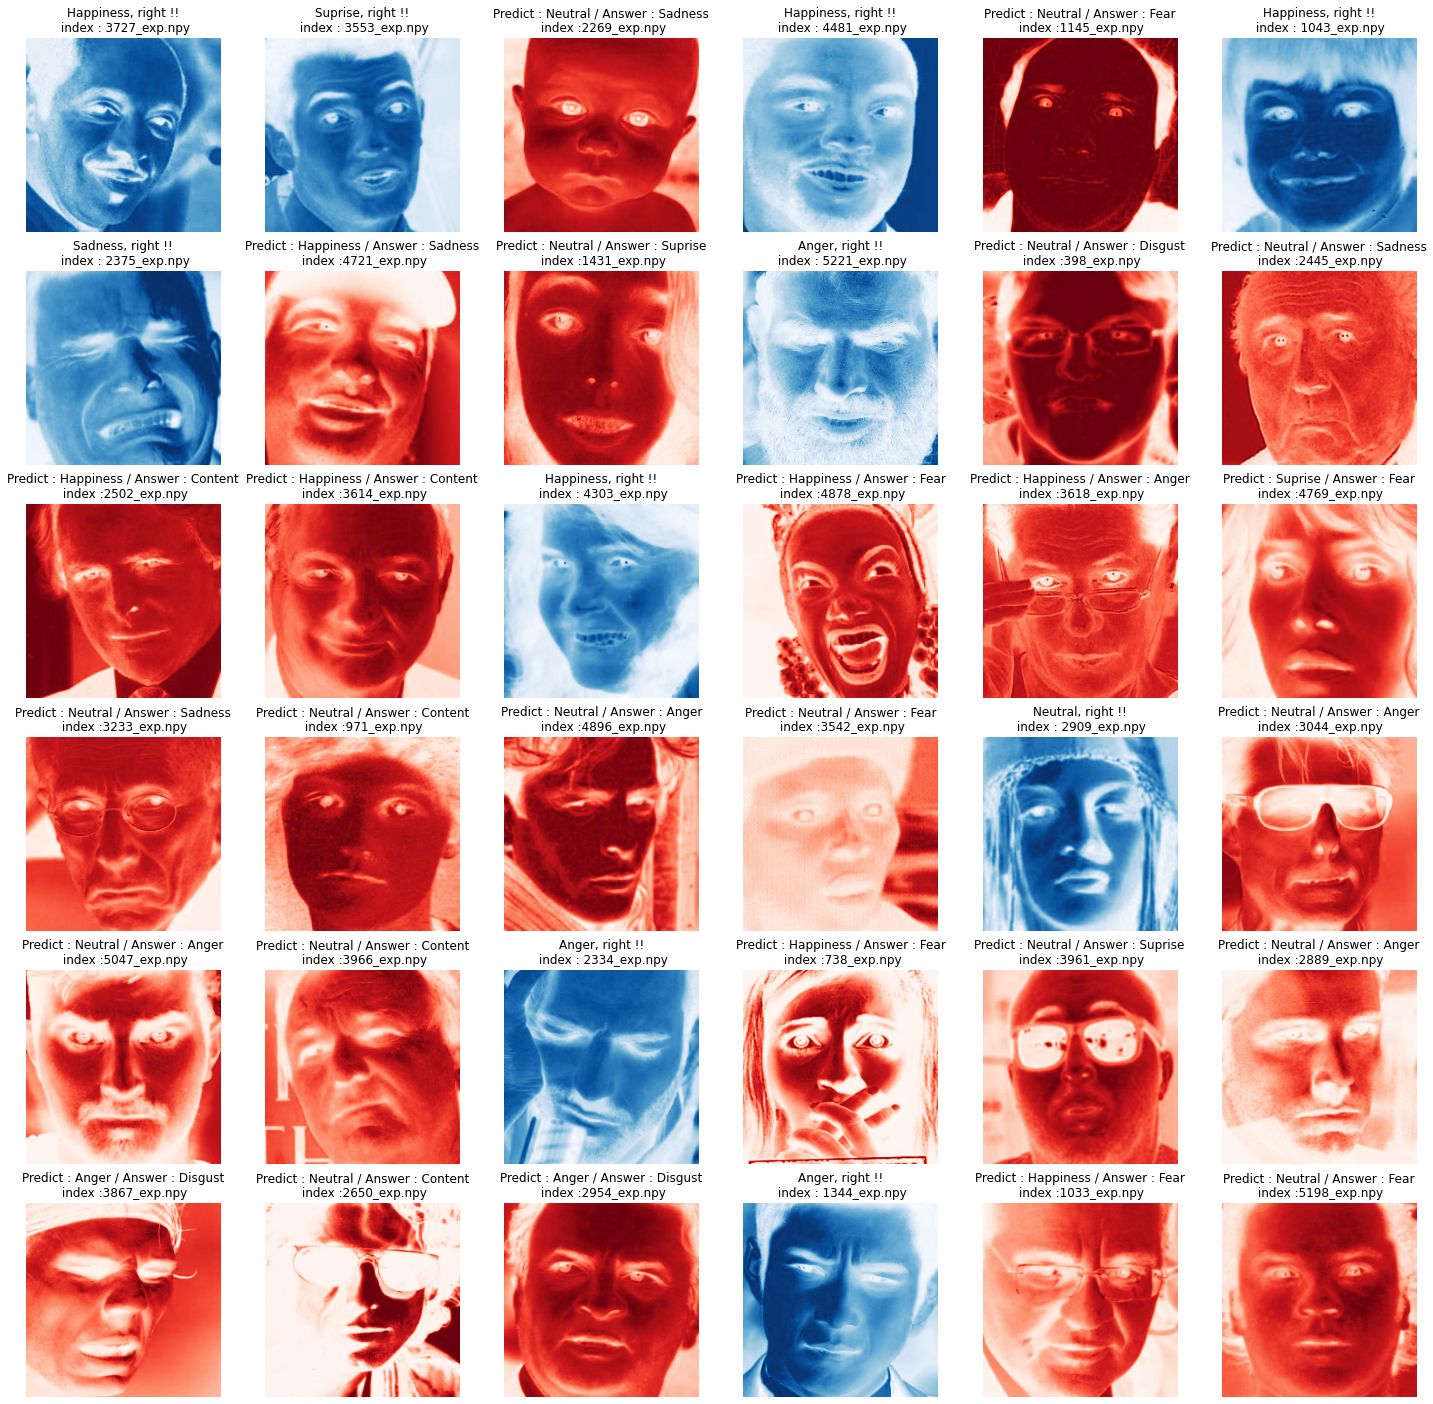

In [19]:
import cv2

columns = 6
rows = 6
fig = plt.figure(figsize=(25,25))

device = "cuda"

# inference
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(4000)
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device) 
    

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    #test_dataset = test_dataset.numpy()
    label = label_tags[test_dataset[data_idx][1].item()]
    
    
    x = label_load("/home/sldev1/Project/hyeongeun_test/data/FER/val_set/annotations/")[data_idx].split('/')
    x = x[-1]
    
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !!\n index : ' + str(x))
        cmap = 'Blues'
    else:
        plt.title('Predict : ' + pred + ' / Answer : ' +  label + '\n index :' + str(x))
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    #plt.imshow(plot_img)
    plt.axis('off')
    
plt.show() 

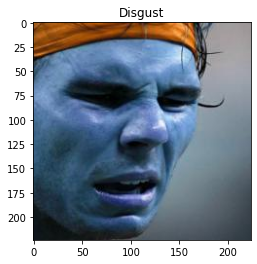

In [22]:
num = 3867
x = cv2.imread(f"/home/sldev1/Project/hyeongeun_test/data/FER/val_set/images/{num}.jpg", cv2.IMREAD_COLOR)
y = int(np.load(f"/home/sldev1/Project/hyeongeun_test/data/FER/val_set/annotations/{num}_exp.npy"))

label_tags = {
    0 : 'Neutral',
    1 : 'Happiness', #기쁨
    2 : 'Sadness', #슬픔
    3 : 'Suprise', #놀람
    4 : 'Fear', #
    5 : 'Disgust', #역겨움
    6 : 'Anger', #분노
    7 : 'Content' #만족
}

plt.title(label_tags[y])
plt.imshow(x)



In [1]:
!tensorboard --logdir=runs

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

----
## 참고자료
- 논문 구현
    - [링크](https://cryptosalamander.tistory.com/158)
- tensorboard
    - [링크](https://gaussian37.github.io/dl-pytorch-observe/#tensorboard%EB%A5%BC-%ED%86%B5%ED%95%9C-%ED%95%99%EC%8A%B5-%ED%98%84%ED%99%A9-%ED%99%95%EC%9D%B8-1)